# Tobig's 21기 2주차 Optimization 과제

# Gradient Descent 구현하기

### 1)"..."표시되어 있는 빈 칸을 채워주세요
### 2)강의내용과 코드에 대해 공부한 내용을 마크다운 또는 주석으로 설명해주세요

## 데이터

In [36]:
import pandas as pd
import numpy as np
import random

In [37]:
data = pd.read_csv('assignment_2.csv')
data.head()

,Label,bias,experience,salary
0,1,1,0.7,48000
1,0,1,1.9,48000
2,1,1,2.5,60000
3,0,1,4.2,63000
4,0,1,6.0,76000


## Train Test 데이터 나누기

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0], test_size = 0.25, random_state = 0)

In [40]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((150, 3), (50, 3), (150,), (50,))

## Scaling

experience와 salary의 단위, 평균, 분산이 크게 차이나므로 scaler를 사용해 단위를 맞춰줍니다.

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
bias_train = X_train["bias"]
bias_train = bias_train.reset_index()["bias"]
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_train["bias"] = bias_train
X_train.head()

,bias,experience,salary
0,1,0.187893,-1.143335
1,1,1.185555,0.043974
2,1,-0.310938,-0.351795
3,1,-1.629277,-1.341220
4,1,-1.308600,0.043974


이때 scaler는 X_train에 fit 해주시고, fit한 scaler를 X_test에 적용시켜줍니다.  
똑같이 X_test에다 fit하면 안돼요!

In [42]:
bias_test = X_test["bias"]
bias_test = bias_test.reset_index()["bias"]
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
X_test["bias"] = bias_test
X_test.head()

,bias,experience,salary
0,1,-1.344231,-0.615642
1,1,0.508570,0.307821
2,1,-0.310938,0.571667
3,1,1.363709,1.956862
4,1,-0.987923,-0.747565


In [43]:
# parameter 개수
N = len(X_train.loc[0])

In [44]:
# 초기 parameter들을 임의로 설정해줍니다.
parameters = np.array([random.random() for i in range(N)])
random_parameters = parameters.copy()
parameters

array([0.93736434, 0.33933399, 0.05096824])

### * LaTeX   

Jupyter Notebook은 LaTeX 문법으로 수식 입력을 지원하고 있습니다.  
LaTeX문법으로 아래의 수식을 완성해주세요  
http://triki.net/apps/3466  
https://jjycjnmath.tistory.com/117

## Dot product
## $Z = X \theta$

In [45]:
def dot_product(X, parameters):
    z = np.dot(X, parameters)
    return z

In [46]:
dot_product

<function __main__.dot_product(X, parameters)>

## Logistic Function

## $ p = \frac{1}{1 + e^{-z}} $

In [47]:
def logistic(X, parameters):
    x = np.dot(X, parameters)
    p = 1 / (1 + np.exp(x * -1))
    return p

In [48]:
logistic(X_train.iloc[1], parameters)

0.7928030133346738

## Object function

Object Function : 목적함수는 Gradient Descent를 통해 최적화 하고자 하는 함수입니다.  
<br>
선형 회귀의 목적함수
## $l(\theta) = \frac{1}{2}\Sigma(y_i - \theta^{T}X_i)^2$  
참고) $\hat{y_i} = \theta^{T}X_i$. 1/2 은 계산상의 편의를 위해 곱합니다
  
로지스틱 회귀의 목적함수를 작성해주세요  
(선형 회귀의 목적함수처럼 sum 형태까지만 작성해주세요. 평균을 고려하는 것은 뒤에 코드에서 수행합니다)
$$l(p) = \sum_{i=1}^{m} \left[ y^{(i)} \log(p^{(i)}) + (1 - y^{(i)}) \log(1 - p^{(i)}) \right]$$



In [72]:
def minus_log_cross_entropy_i(X, y, parameters):
    p = sigmoid(np.dot(X, parameters))
    loss = -y * np.log(p) - (1 - y) * np.log(1 - p)
    return loss

In [50]:
def mse_i(X, y, parameters):
    loss = (y - np.dot(X, parameters)) ** 2
    return loss

In [51]:
def batch_loss(X_set, y_set, parameters, loss_function, n): #n: 현재 배치의 데이터 수
    loss = 0
    for i in range(n):
        loss += loss_function(X_set.iloc[i], y_set.iloc[i], parameters)
    loss = loss/n #loss 평균값으로 계산
    return loss

In [52]:
batch_loss(X_test, y_test, parameters, mse_i, len(X_test))

1.0044551029527442

In [53]:
batch_loss(X_test, y_test, parameters, minus_log_cross_entropy_i, len(X_test))

0.6092209848067772

## Gradient
위의 선형회귀의 목적함수 $l(\theta)$와 로지스틱회귀의 목적함수 $l(p)$의 gradient를 작성해주세요  
(위의 목적함수를 참고해서 작성해주세요 = 평균을 고려하는 것은 뒤에 코드에서 수행합니다)

## ${\partial\over{\partial \theta_j}}l(\theta)=\sum^n_{i=1} (y_i - \theta^T X_i) \cdot (-X_i)$
## ${\partial\over{\partial \theta_j}}l(p)=\sum^n_{i=1} (y_i−p(X_i))$

In [54]:
def get_gradient_ij(X, y, parameters, j, model):
    if model == 'linear':
        gradient = (y - np.dot(parameters, X.iloc[j])) * (-1 * X.iloc[j])
    else:
        gradient = y - logistic(X.iloc[j], parameters)
    return gradient

In [55]:
get_gradient_ij(X_train.iloc[0,:], y_train.iloc[0], parameters, 1, 'linear')

array([-0.15480052, -0.17591326, -0.18609367])

In [56]:
get_gradient_ij(X_train.iloc[0,:], y_train.iloc[0], parameters, 1, 'logistic')

array([0.45608241, 0.48406577, 0.49760587])

In [ ]:
from IPython.display import Image

Image("C:/Users/rhskr/Desktop/배치알고리즘_구현.png")

## Batch Gradient
하나의 배치 (X_set, y_set)에 대해 기울기를 구하는 코드를 작성해주세요

In [58]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def batch_gradient(X_set, y_set, parameters, model):
    m = len(y_set)
    if model == 'linear':
        # For linear regression, the hypothesis is just the dot product of X and theta
        predictions = np.dot(X_set, parameters)
        errors = predictions - y_set
        gradients = np.dot(X_set.T, errors) / m
    elif model == 'logistic':
        # For logistic regression, the hypothesis is the sigmoid of the dot product of X and theta
        z = np.dot(X_set, parameters)
        predictions = sigmoid(z)
        errors = predictions - y_set
        gradients = np.dot(X_set.T, errors) / m
    else:
        raise ValueError("Model must be 'linear' or 'logistic'.")


    return gradients

In [59]:
gradients1 = batch_gradient(X_train, y_train, parameters, 'linear')
gradients1

array([0.65736434, 0.25662334, 0.39653287])

In [60]:
gradients1 = batch_gradient(X_train, y_train, parameters, 'logistic')
gradients1

array([ 0.43236084, -0.04597624,  0.15326181])

## mini-batch
인덱스로 미니 배치 나누기

In [61]:
def batch_idx(X_train, batch_size):
    N = len(X_train)
    nb = (N // batch_size)+1 #number of batch
    idx = np.array([i for i in range(N)])
    idx_list = [idx[i*batch_size:(i+1)*batch_size] for i in range(nb) if len(idx[i*batch_size:(i+1)*batch_size]) != 0]
    return idx_list

*batch_idx* 함수에 대한 설명을 batch_size와 함께 간략하게 작성해주세요  
### 설명:

batch_idx 함수는 데이터셋을 작은 batch로 나누기 위해 인덱스 목록을 생성합니다. 이 함수는 특히 batch gradient descent을 사용하여 머신러닝 모델을 훈련할 때 유용하게 사용되는데, 전체 데이터셋을 한 번에 처리하기에는 너무 큰 경우에 사용합니다. 함수 내 batch_size는 각 batch의 크기로, 한 batch에 포함시키고자 하는 샘플의 수를 의미합니다.

함수에서는 batch 수만큼의 범위로 반복하면서 인덱스 배열을 batch_size 길이의 하위 배열로 나눕니다. 이 하위 배열들은 각 batch에 대한 인덱스를 나타냅니다.
batch_size로 완벽하게 나누어 떨어지지 않아 빈 batch가 생길 수 있는 경우를 대비해, 빈 batch는 포함하지 않도록 조건을 추가합니다.

## Update Parameters
기울기를 갱신하는 코드를 작성해주세요  
(loss와 마찬가지로 기울기를 갱신할 때 배치 사이즈를 고려해 평균으로 갱신해주세요)

In [62]:
def step(parameters, gradients, learning_rate, n): #n: 현재 배치의 데이터 수
    parameters = parameters - (learning_rate / n) * gradients
    return parameters

In [63]:
step(parameters, gradients1, 0.01, len(X_train))

array([0.93733552, 0.33933705, 0.05095802])

## Gradient Descent
위에서 작성한 함수들을 조합해서 경사하강법 함수를 완성해주세요

- learning_rate:  매 스텝에서 파라미터를 얼마나 업데이트할지 결정하는 hyperparameter  
- tolerance: Step이 너무 작아서 더 이상의 학습이 무의미할 때 학습을 멈추는 조건  
- batch: 데이터셋을 나누어 학습하는 단위로, 배치 크기에 따라 경사하강법의 종류가 결정됨.
- epoch: 전체 데이터셋을 한 번 학습하는 주기
- num_epoch: 최대 에폭 수; 모델을 학습시킬 총 에폭의 수
<br>

BGD: Batch Gradient Descent, 전체 데이터셋을 사용해서 한 번에 gradient 계산함.
SGD: Stochastic Grandient Descent, 각 스텝마다 임의로 선택한 하나의 데이터만 사용해서 gradient 계산.
MGD: Mini-batch Grandient Descent, 미니배치를 사용하여(데이터셋의 일부) grandient 계산.


<br>
batch_size에 따른 경사하강법의 종류를 적어주세요

batch_size=1 ->  SGD(Stochastic Gradient Descent)  
batch_size=k ->  MGD(Mini-batch Gradient Descent)
batch_size=whole -> BGD(Batch Gradient Descent)

In [75]:
def gradient_descent(X_train, y_train, learning_rate = 0.1, num_epoch = 1000, tolerance = 0.00001, model = 'logistic', batch_size = 16):
    stopper = False

    N = len(X_train.iloc[0])
    parameters = np.random.rand(N)
    loss_function = minus_log_cross_entropy_i if model == 'logistic' else mse_i
    loss = 999
    batch_idx_list = batch_idx(X_train, batch_size)

    for epoch in range(num_epoch):
        if stopper:
            break
        for idx in batch_idx_list:
            X_batch = X_train.iloc[idx,]
            y_batch = y_train.iloc[idx]
            # 기울기 계산
            gradients = batch_gradient(X_batch, y_batch, parameters, model)

            # 파라미터 업데이트
            parameters = parameters - learning_rate * gradients

            # 새로운 손실 계산
            new_loss = np.mean([loss_function(X_batch.iloc[i], y_batch.iloc[i], parameters) for i in range(len(y_batch))])

            if model == 'logistic':
                predictions = sigmoid(np.dot(X_batch, parameters))
                new_loss = batch_loss(X_batch, y_batch, parameters, minus_log_cross_entropy_i, len(y_batch))
            else:  # 'linear' model
                predictions = np.dot(X_batch, parameters)
                new_loss = batch_loss(X_batch, y_batch, parameters, mse_i, len(y_batch))

            #중단 조건
            if abs(new_loss - loss) < tolerance:
                stopper = True
                break
            loss = new_loss

        #100epoch마다 학습 상태 출력
        if epoch%100 == 0: #출력이 길게 나오면 check point를 수정해도 됩니다.
            print(f"epoch: {epoch}  loss: {new_loss}  params: {parameters}  gradients: {gradients}")

    return parameters

## Implement
경사하강법 함수를 이용해 최적의 모수를 찾아보세요. 학습을 진행할 때, hyperparameter를 바꿔가면서 학습시켜보세요.

## Logistic Regression

default: learning_rate = 0.1, num_epoch = 1000, tolerance = 0.00001, model = 'logistic', batch_size = 16

In [76]:
new_param_bgd = gradient_descent(X_train, y_train, batch_size=X_train.shape[0])
new_param_bgd

epoch: 0  loss: 1.0031771577623028  params: [0.85142602 0.68668    0.31408909]  gradients: [0.39482238 0.0559986  0.25025907]
epoch: 100  loss: 0.44367563558526496  params: [-0.78485277  0.96863615 -0.87946661]  gradients: [ 0.04810944 -0.05611325  0.06108354]
epoch: 200  loss: 0.38676491713675615  params: [-1.04017785  1.46274618 -1.37749063]  gradients: [ 0.01435112 -0.04260553  0.04168206]
epoch: 300  loss: 0.3586007741256056  params: [-1.15012506  1.83372833 -1.7385799 ]  gradients: [ 0.00893148 -0.03243491  0.03144237]
epoch: 400  loss: 0.34182758298457666  params: [-1.22901844  2.12220204 -2.01738138]  gradients: [ 0.00707657 -0.02576467  0.02482526]
epoch: 500  loss: 0.33093929117355264  params: [-1.2937728   2.35521211 -2.24131405]  gradients: [ 0.00595018 -0.02114321  0.02026736]
epoch: 600  loss: 0.32344848735639253  params: [-1.34884152  2.54878617 -2.42646086]  gradients: [ 0.00510665 -0.01776896  0.01695858]
epoch: 700  loss: 0.318074059751346  params: [-1.39640038  2.7129

array([-1.50654417,  3.08538196, -2.93547693])

In [77]:
new_param_sgd = gradient_descent(X_train, y_train, batch_size=1)
new_param_sgd

epoch: 0  loss: 0.281393476836062  params: [-0.85861574  1.10983911 -1.23561497]  gradients: [0.25378042 0.13810755 0.17855756]
epoch: 100  loss: 0.07736670642438695  params: [-1.93032576  4.17501973 -4.06769134]  gradients: [0.07538543 0.04102482 0.05304049]
epoch: 200  loss: 0.07736266552093428  params: [-1.9303681   4.1751431  -4.06780374]  gradients: [0.0753816  0.04102274 0.05303779]
epoch: 300  loss: 0.07736266518361704  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.07538159 0.04102274 0.05303779]
epoch: 400  loss: 0.07736266518359017  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.07538159 0.04102274 0.05303779]
epoch: 500  loss: 0.07736266518359017  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.07538159 0.04102274 0.05303779]
epoch: 600  loss: 0.07736266518359017  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.07538159 0.04102274 0.05303779]
epoch: 700  loss: 0.07736266518359017  params: [-1.9303681   4.17514311 -4.06780

array([-1.9303681 ,  4.17514311, -4.06780375])

In [78]:
new_param_mgd = gradient_descent(X_train, y_train)
new_param_mgd

epoch: 0  loss: 1.0877018089824233  params: [0.05319802 0.82306306 0.08478931]  gradients: [0.54021216 0.51316289 0.64749057]
epoch: 100  loss: 0.19686128919579712  params: [-1.5702679   3.0995004  -3.04558363]  gradients: [0.07384245 0.10896628 0.14450428]
epoch: 200  loss: 0.1676163510538896  params: [-1.77739205  3.75817494 -3.66716498]  gradients: [0.06966446 0.10557075 0.13047232]
epoch: 300  loss: 0.15702464372831224  params: [-1.87014701  4.04826759 -3.9386088 ]  gradients: [0.0685332  0.10442508 0.1254438 ]
epoch: 400  loss: 0.1521403114011768  params: [-1.91715357  4.19447799 -4.07490772]  gradients: [0.06808523 0.10391338 0.12313587]
epoch: 500  loss: 0.149654594891066  params: [-1.94224828  4.2723417  -4.14735651]  gradients: [0.06787531 0.1036569  0.12196399]
epoch: 600  loss: 0.14832778107381098  params: [-1.95598999  4.31492675 -4.18694044]  gradients: [0.06776826 0.10352106 0.1213392 ]
epoch: 700  loss: 0.1476017487394918  params: [-1.9636155   4.3385424  -4.20887984]  g

array([-1.97160415,  4.36327111, -4.23184418])

### Predict Label

In [79]:
# bgd 활용하여 학습한 parameters로 예측
y_predict = []
for i in range(len(y_test)):
    p = logistic(X_test.iloc[i,:], new_param_bgd)
    if p> 0.5 :
        y_predict.append(1)
    else :
        y_predict.append(0)

# 초기에 설정한 random parameters로 예측
y_predict_random = []
for i in range(len(y_test)):
    p = logistic(X_test.iloc[i,:], random_parameters)
    if p> 0.5 :
        y_predict_random.append(1)
    else :
        y_predict_random.append(0)

### Confusion Matrix

In [80]:
from sklearn.metrics import *

In [81]:
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
confusion_matrix(y_test, y_predict)

array([[38,  2],
       [ 4,  6]])

In [82]:
accuracy = (tp+tn) / (tp+fn+fp+tn)
print("accuracy:",accuracy)

accuracy: 0.88


## Linear regression
### $y = 0.5 + 2.7x$

### Data

In [83]:
raw_X = np.random.rand(150)
y = 2.7*raw_X + 0.5 + np.random.randn(150)

In [84]:
tmp = np.array([1 for _ in range(150)])
X = np.vstack((tmp, raw_X)).T
X = pd.DataFrame(X)
y = pd.Series(y)

### Estimation

In [85]:
#정규방정식
theta = np.linalg.inv(np.dot(X.T,X)).dot(X.T).dot(y)
theta

array([0.39388326, 2.86850012])

In [86]:
#경사하강법
new_param = gradient_descent(X, y, model = 'linear')
new_param

epoch: 0  loss: 0.6427429510629817  params: [0.91047603 1.03780206]  gradients: [-0.40342418 -0.36703657]
epoch: 100  loss: 0.15251548253388045  params: [0.38329278 2.92799297]  gradients: [0.16187584 0.02777964]
epoch: 200  loss: 0.1521770209982502  params: [0.3817334  2.93104433]  gradients: [0.1619752  0.02797834]
epoch: 300  loss: 0.15217641984858338  params: [0.38173062 2.93104976]  gradients: [0.16197537 0.0279787 ]
epoch: 400  loss: 0.15217641877945515  params: [0.38173062 2.93104977]  gradients: [0.16197537 0.0279787 ]
epoch: 500  loss: 0.1521764187775539  params: [0.38173062 2.93104977]  gradients: [0.16197537 0.0279787 ]
epoch: 600  loss: 0.1521764187775507  params: [0.38173062 2.93104977]  gradients: [0.16197537 0.0279787 ]
epoch: 700  loss: 0.1521764187775507  params: [0.38173062 2.93104977]  gradients: [0.16197537 0.0279787 ]
epoch: 800  loss: 0.1521764187775507  params: [0.38173062 2.93104977]  gradients: [0.16197537 0.0279787 ]
epoch: 900  loss: 0.1521764187775507  param

array([0.38173062, 2.93104977])

In [87]:
y_hat_NE = theta.dot(X.T)
y_hat_GD = new_param.dot(X.T)

### Visualization
시각화를 통해 정규방정식과 경사하강법을 통한 선형회귀를 비교해보세요  
(밑의 코드를 실행만 시키면 됩니다. 추가 코드 x)

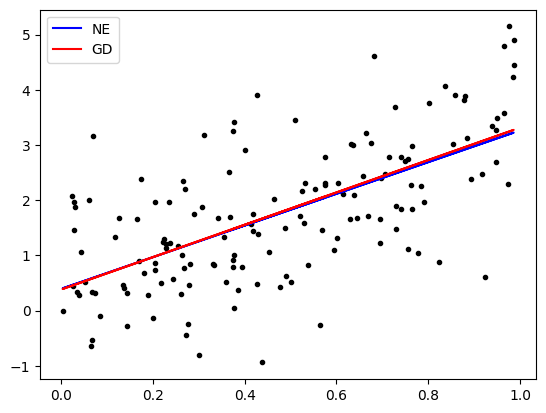

In [88]:
import matplotlib.pyplot as plt
plt.plot(X.iloc[:,1], y, '.k') #산점도
plt.plot(X.iloc[:,1], y_hat_NE, '-b', label = 'NE') #정규방정식
plt.plot(X.iloc[:,1], y_hat_GD, '-r', label = 'GD') #경사하강법
plt.legend()
plt.show()